In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import  LinearRegression, Ridge
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [2]:
df2=pd.read_csv("../data/df_train_kcal.csv")

## **MODELOS**

El objetivo será conseguir un buen modelo con la menos cantidad de datos posibles, para así facilitar al usuario la experiencia en la app

### **MODELO NO SUPERVISADO**

In [3]:
X= df2.drop(columns="Calories_Burned")
y= df2["Calories_Burned"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(99, 17)
(25, 17)
(99,)
(25,)


In [6]:
scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

In [7]:
# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [8]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=17))

# Entrenar PCA en los datos escalados
X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

# Obtener el modelo PCA entrenado
modelo_pca = pca_pipeline.named_steps["pca"] 

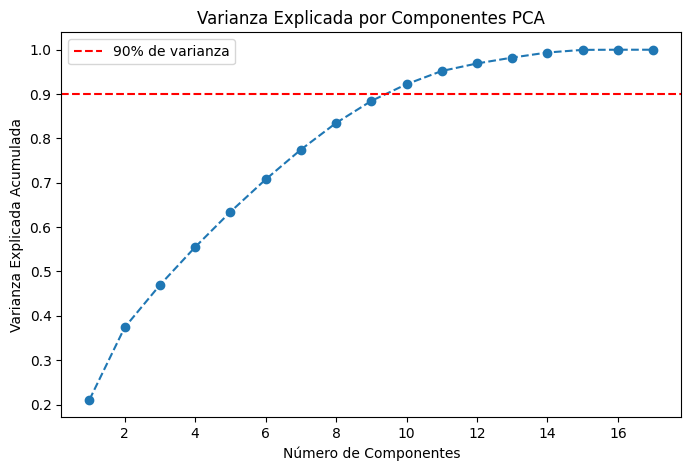

In [9]:

varianza_explicada = np.cumsum(modelo_pca.explained_variance_ratio_)

# Gráfico para ver cuántos componentes capturan al menos el 90% de la varianza
plt.figure(figsize=(8,5))
plt.plot(range(1, len(varianza_explicada) + 1), varianza_explicada, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--', label="90% de varianza")
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes PCA')
plt.legend()
plt.show()

----------------------

Guardamos el **modelo no supervisado**

In [10]:
import pickle

In [11]:
with open("../modelos/PCA.pkl", "wb") as archiv_model_pca:
    pickle.dump(modelo_pca, archiv_model_pca)

-------------------

### **MODELOS SUPERVISADOS**

R2 score 0.8825940816912843
R2 score train 0.9888298653426179
MAE 82.18039999999999
MSE 11785.180908000002
RMSE 108.55957308316941
Age                              0.017871
Weight (kg)                      0.008506
Height (m)                       0.009286
Max_BPM                          0.012279
Avg_BPM                          0.052002
Resting_BPM                      0.005769
Session_Duration (hours)         0.741084
Fat_Percentage                   0.081982
Water_Intake (liters)            0.002686
Workout_Frequency (days/week)    0.002380
Experience_Level                 0.047976
BMI                              0.004940
Male                             0.002558
Workout_Type_Cardio              0.000760
Workout_Type_HIIT                0.000759
Workout_Type_Strength            0.008770
Workout_Type_Yoga                0.000390
dtype: float64


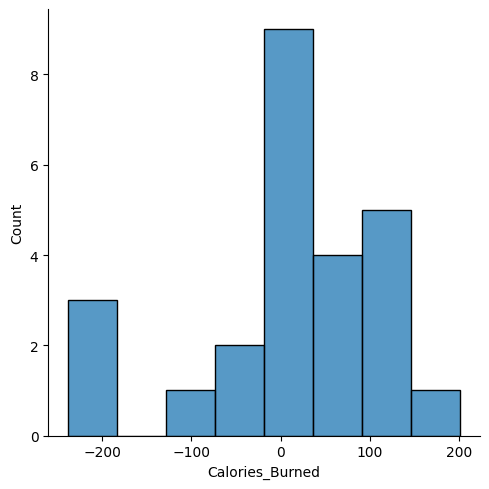

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Crear y entrenar el modelo
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Realizar predicciones
y_pred_rf = model_rf.predict(X_test)
print("R2 score", model_rf.score(X_test, y_test))
print("R2 score train",model_rf.score(X_train, y_train))
print("MAE", mean_absolute_error(y_test, y_pred_rf))
print("MSE", mean_squared_error(y_test, y_pred_rf))
print("RMSE", mean_squared_error(y_test, y_pred_rf) ** (1/2))
sns.displot(y_pred_rf - y_test)
feature_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
print(feature_importances)

Sabiendo las columnas que no queremos coger ya que es probable que le usuario no conozca esos datos(como las pulsaciones en la sesión de ejercicio) podemos descartar también las columnas de nivel y frecuencia ya que también estaban altamente correlacionadas con la duración de la sesión

Vamos a coger 11 variables que pueden ser interesantes para el modelo predictivo

In [13]:
X1= df2[['Age', 'Weight (kg)', 'Height (m)','Session_Duration (hours)','Fat_Percentage','Workout_Type_Cardio',
       'Workout_Type_HIIT', 'Workout_Type_Strength', 'Workout_Type_Yoga',"Male","BMI"]]
y1= df2["Calories_Burned"]

In [14]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [15]:
print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(99, 11)
(25, 11)
(99,)
(25,)


In [16]:
scaler = StandardScaler()

X1_train_scal = scaler.fit_transform(X1_train)
X1_test_scal = scaler.transform(X1_test)

Entrenamos con varios modelo supervisados para ver cual nos da mejor resultado

como es de Regresión lineal y queremos ver los mismos datos en todos los modelos creamos una función

In [17]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R2 score", model.score(X_test, y_test))
    print("R2 score train", model.score(X_train, y_train))
    print("MAE", mean_absolute_error(y_test, y_pred))
    print("MSE", mean_squared_error(y_test, y_pred))
    print("RMSE", mean_squared_error(y_test, y_pred) ** (1/2))
    sns.displot(y_pred - y_test)
    return model

R2 score 0.9837518637271765
R2 score train 0.9799543996596408
MAE 32.8835443552492
MSE 1630.9844354656027
RMSE 40.38544831329229


LinearRegression()

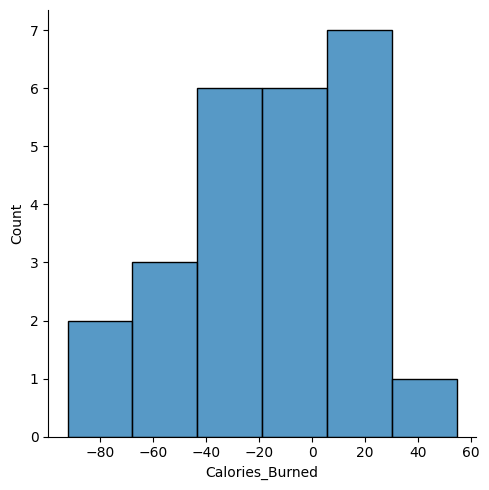

In [18]:
model_1 = train_evaluate_model(LinearRegression(), X_train_pca, y1_train, X_test_pca, y1_test)
model_1

In [19]:
with open("../modelos/pca_reg_ejer.pkl", "wb") as model_pca_reg_ejer:
    pickle.dump(model_1, model_pca_reg_ejer)

Usando X de PCA es muy posible que tengamos overfitting entinces aunque los datos sean mejores en este modelo vamos a usar un X_train

R2 score 0.8638967461694906
R2 score train 0.8712806087783788
MAE 93.23971294790644
MSE 13662.015438968912
RMSE 116.88462447631387


LinearRegression()

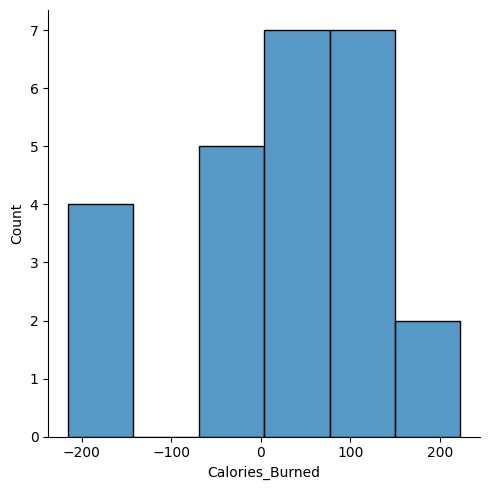

In [20]:
model_2 = train_evaluate_model(LinearRegression(), X1_train_scal, y1_train, X1_test_scal, y1_test)
model_2

R2 score 0.863896746169491
R2 score train 0.8712806087783787
MAE 93.23971294790623
MSE 13662.01543896887
RMSE 116.88462447631369


LinearRegression()

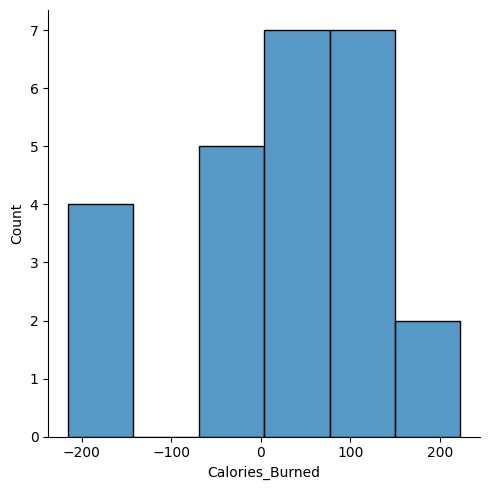

In [21]:
model_3 = train_evaluate_model(LinearRegression(), X1_train, y1_train, X1_test, y1_test)
model_3

Con modelos de regresión lineal no varía si usamos datos escalados o sin escalar

R2 score 0.812155509388752
R2 score train 0.8504839443356158
MAE 120.8632355610341
MSE 18855.789693698283
RMSE 137.3163853795252


Ridge(alpha=2)

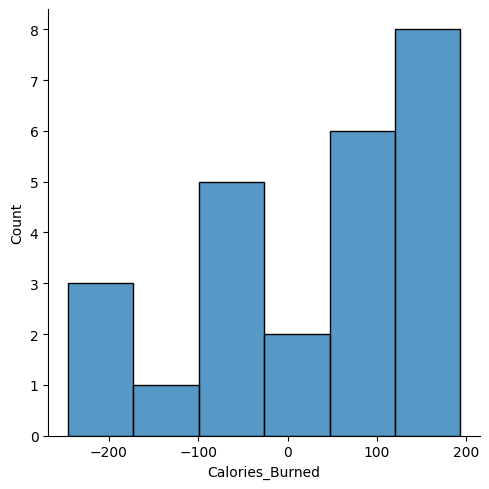

In [22]:
model_4 = train_evaluate_model(Ridge(alpha=2), X1_train, y1_train, X1_test, y1_test)
model_4

Obtenemos unos valores muy similares a los modelos anteriores, pero ligeramente peores

R2 score 0.3834344310470016
R2 score train 0.9520347633473771
MAE 204.06796791099086
MSE 61890.719619843985
RMSE 248.7784548947999


LinearRegression()

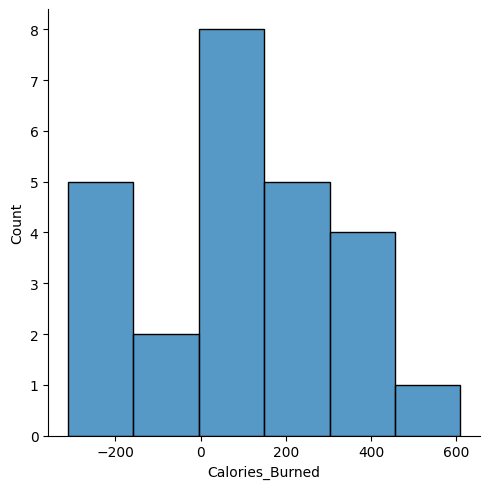

In [23]:
pol_2= PolynomialFeatures(degree=2)

X_train_pol2 = pol_2.fit_transform(X1_train)
X_test_pol2 = pol_2.transform(X1_test)

model_5 = train_evaluate_model(LinearRegression(), X_train_pol2, y1_train, X_test_pol2, y1_test)
model_5

In [24]:
# Guardar el transformador PolynomialFeatures
with open("../modelos/pol2_transform_ejer.pkl", "wb") as pol_transf_ejer:
    pickle.dump(pol_2, pol_transf_ejer)

In [25]:
with open("../modelos/pol2_ejer.pkl", "wb") as model_pol2_ejer:
    pickle.dump(model_5, model_pol2_ejer)

R2 score 0.8209540872436085
R2 score train 0.9810151019084998
MAE 105.94538599877252
MSE 17972.59033504288
RMSE 134.06188994282783


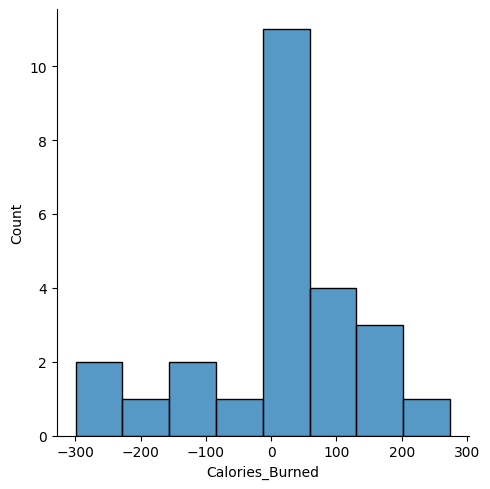

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rnd_reg = RandomForestRegressor(n_estimators=200,
                                 max_leaf_nodes=32,
                                 random_state=42)
rnd_reg.fit(X1_train, y1_train)

y_pred_reg = rnd_reg.predict(X1_test)
print("R2 score", rnd_reg.score(X1_test, y1_test))
print("R2 score train",rnd_reg.score(X1_train, y1_train))
print("MAE", mean_absolute_error(y1_test, y_pred_reg))
print("MSE", mean_squared_error(y1_test, y_pred_reg))
print("RMSE", mean_squared_error(y1_test, y_pred_reg) ** (1/2))
sns.displot(y_pred_reg - y1_test)

In [134]:
with open("../modelos/rnd_ejer.pkl", "wb") as model_rnd_ejer:
    pickle.dump(rnd_reg, model_rnd_ejer)

Valorando todos los modelos tenemos que los mejor son el polinímico de grado dos y el RandomForest.

En el primero tenemenos una bajada de la cantidad de datos en la dispersión, se centran entorno a 0 auqnue tenemos algunas irregularidades. El R2 score es muy alto en train y ha bajado en test ligeramente,mientras que en el random forest sube un poco en test. Respecto a la metrica qeu estamos usando para guiarnos vemos que el Mae es mucho mejor en el modelo polinomico

-------------------------

Evaluamos con el datset de test

In [ ]:
df_kcal=pd.read_csv("../data/df_test_kcal.csv")

In [ ]:
X_kcl= df_kcal[['Age', 'Weight (kg)', 'Height (m)','Session_Duration (hours)','Fat_Percentage','Workout_Type_Cardio',
       'Workout_Type_HIIT', 'Workout_Type_Strength', 'Workout_Type_Yoga',"Male","BMI"]]


C:\Users\UX490U\AppData\Local\Temp\ipykernel_7512\2296361264.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_kcal=df_kcal.replace({True:1,False:0})


Hacemos predicciones con el modelos de pol_2 y con el rnd

In [140]:
X_kcl_pol2 = pol_2.transform(X_kcl)
y_pred_kcal_pol2 = model_5.predict(X_kcl_pol2)

In [141]:
y_pred_kcal_pol2=np.round(y_pred_kcal_pol2)

In [142]:
prediccion_pol2=pd.DataFrame({"kcal":y_pred_kcal_pol2,"Kcal_real":df_kcal["Calories_Burned"]})

In [169]:
prediccion_pol2[8:15]

,kcal,Kcal_real
8,441.0,454.0
9,1148.0,1107.0
10,699.0,576.0
11,507.0,433.0
12,1015.0,911.0
13,994.0,864.0
14,693.0,621.0


In [168]:
y_pred_kcal_rnd = np.round(rnd_reg.predict(X_kcl))
prediccion_rnd=pd.DataFrame({"kcal":y_pred_kcal_rnd,"Kcal_real":df_kcal["Calories_Burned"]})
prediccion_rnd[8:15]

,kcal,Kcal_real
8,496.0,454.0
9,1118.0,1107.0
10,737.0,576.0
11,507.0,433.0
12,997.0,911.0
13,1010.0,864.0
14,733.0,621.0


**Evaluamos que modelo de los escogidos nos da mejores resultados en test**

In [145]:
df_comprobar_pol2=pd.DataFrame({"y_pred":prediccion_pol2["kcal"],"y_real": df_kcal["Calories_Burned"]})

In [146]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(df_comprobar_pol2["y_real"], df_comprobar_pol2["y_pred"])
mse = mean_squared_error(df_comprobar_pol2["y_real"], df_comprobar_pol2["y_pred"])
rmse = np.sqrt(mse)
r2 = r2_score(df_comprobar_pol2["y_real"],df_comprobar_pol2["y_pred"])

# Mostrar resultados
print(f"MAE: {mae:.2f} kcal")
print(f"RMSE: {rmse:.2f} kcal")
print(f"R² Score: {r2:.2f}")#(Cuanto más cerca de 1, mejor)

MAE: 85.37 kcal
RMSE: 107.15 kcal
R² Score: 0.86


In [147]:
df_comprobar_rnd=pd.DataFrame({"y_pred":prediccion_rnd["kcal"],"y_real": df_kcal["Calories_Burned"]})

In [148]:
mae = mean_absolute_error(df_comprobar_rnd["y_real"], df_comprobar_rnd["y_pred"])
mse = mean_squared_error(df_comprobar_rnd["y_real"], df_comprobar_rnd["y_pred"])
rmse = np.sqrt(mse)
r2 = r2_score(df_comprobar_rnd["y_real"],df_comprobar_rnd["y_pred"])

# Mostrar resultados
print(f"MAE: {mae:.2f} kcal")
print(f"RMSE: {rmse:.2f} kcal")
print(f"R² Score: {r2:.2f}")#(Cuanto más cerca de 1, mejor)

MAE: 88.28 kcal
RMSE: 109.79 kcal
R² Score: 0.85


El modelo polinomico nos da resultados ligeramnete peores, por lo que nos quedaremos con el random_forest para hacer las predicciones

--------------------------

-----------------------------